##   STEP0: 런타임 준비 + 기본 설정




In [2]:
#!pip -q install -U sentence-transformers transformers peft datasets

import os, sys, json
import numpy as np, pandas as pd
print("Python:", sys.version)

# 경로/하이퍼파라미터 공통
DEBERTA_DIR = "/kaggle/input/deberta-v3-small-local"
QWEN3_DIR = "/kaggle/input/all-minilm-l6-v2/all-MiniLM-L6-v2"  
DATA_DIR = "/kaggle/input/llm-classification-finetuning"  # Colab/로컬이면 적절히 교체
WORK_DIR = "/kaggle/working"

BASE_ARGS = {
    "DATA_DIR": DATA_DIR,
    "WORK_DIR": WORK_DIR,
    "train_path": f"{DATA_DIR}/train.csv",
    "test_path":  f"{DATA_DIR}/test.csv",
    "submit_path": f"{DATA_DIR}/sample_submission.csv",
    "embed_model_dir": QWEN3_DIR,  
    "embed_batch_size": 64,         
    "random_state": 42,
    "val_size": 0.2,
}

# 파일 존재 확인
for k in ["train_path","test_path","submit_path"]:
    print(k, os.path.exists(BASE_ARGS[k]), "->", BASE_ARGS[k])


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
train_path True -> /kaggle/input/llm-classification-finetuning/train.csv
test_path True -> /kaggle/input/llm-classification-finetuning/test.csv
submit_path True -> /kaggle/input/llm-classification-finetuning/sample_submission.csv


## STEP0: Data preprocessing + labeling

In [3]:
from typing import Dict, Tuple, Optional, List
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import MaxAbsScaler

def load_csvs(cfg: Dict):
    train = pd.read_csv(cfg["train_path"])
    test  = pd.read_csv(cfg["test_path"])
    submit= pd.read_csv(cfg["submit_path"])
    print(f"[io] train:{train.shape}, test:{test.shape}, submit:{submit.shape}")
    return train, test, submit

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    low = {c.lower(): c for c in df.columns}
    if "response_a" in low: df = df.rename(columns={low["response_a"]: "response_A"})
    if "response_b" in low: df = df.rename(columns={low["response_b"]: "response_B"})
    if "prompt" not in df.columns: df["prompt"] = ""
    return df
    
def build_label_threeway(train: pd.DataFrame) -> pd.DataFrame:
    low = {c.lower(): c for c in train.columns}
    need = {"winner_model_a","winner_model_b","winner_tie"}
    if not need.issubset(set(low)):
        raise ValueError("3-class 라벨 생성 불가: winner_* 세 컬럼 필요")

    a = pd.to_numeric(train[low["winner_model_a"]], errors="coerce").fillna(0).astype(int)
    b = pd.to_numeric(train[low["winner_model_b"]], errors="coerce").fillna(0).astype(int)
    t = pd.to_numeric(train[low["winner_tie"]],     errors="coerce").fillna(0).astype(int)

    # 각 행에서 하나만 1이라고 가정(여러 개 1인 이상치는 A/B/tie 우선순위로 최대값 선택)
    label3 = np.argmax(np.stack([a.values, b.values, t.values], axis=1), axis=1).astype(int)

    out = train.copy()
    out["label"] = label3  # 0:A, 1:B, 2:tie
    print("[pre/3way] shape:", out.shape,
          " label counts:", dict(pd.Series(label3).value_counts().sort_index()))
    return out

def save_submission_threecols(test_df: pd.DataFrame,
                              probs_3: np.ndarray,  # shape (N, 3) → softmax된 확률
                              out_path: str):
    assert probs_3.ndim == 2 and probs_3.shape[1] == 3, "probs_3 must be (N,3)"
    p = np.clip(probs_3, 1e-7, 1-1e-7)
    p = p / p.sum(axis=1, keepdims=True)  # 혹시 모를 드리프트 교정

    sub = pd.DataFrame({
        "id": test_df["id"].values,
        "winner_model_a": p[:, 0],
        "winner_model_b": p[:, 1],
        "winner_tie":     p[:, 2],
    })

    # sanity check
    s = sub[["winner_model_a","winner_model_b","winner_tie"]].sum(1).to_numpy()
    assert np.allclose(s, 1.0, atol=1e-6), "probabilities must sum to 1"

    sub.to_csv(out_path, index=False)
    print("[save]", out_path)
    print(sub.head())

from sklearn.preprocessing import MaxAbsScaler
def stable_softmax(logits):
    # logits: (n, C)
    m = logits.max(axis=1, keepdims=True)
    z = logits - m
    np.clip(z, -50, 50, out=z)     # 안전 클리핑
    ez = np.exp(z, dtype=np.float64)
    s = ez.sum(axis=1, keepdims=True)
    # s==0 방지
    s[s == 0] = 1.0
    p = ez / s
    # NaN/Inf 방지
    p = np.nan_to_num(p, nan=1.0/p.shape[1], posinf=1.0/p.shape[1], neginf=0.0)
    # 정규화 재확인
    p = p / p.sum(axis=1, keepdims=True)
    return p

def _stack_with_scaled_handcrafted(X, Xt, train, test):
    # 부가 특성 스케일링
    extra_tr = np.hstack([add_length_feats(train).values,
                          add_bias_feats(train).values]).astype(np.float32)
    extra_te = np.hstack([add_length_feats(test).values,
                          add_bias_feats(test).values]).astype(np.float32)
    scaler = MaxAbsScaler()  # 희소-친화
    extra_tr = scaler.fit_transform(extra_tr)
    extra_te = scaler.transform(extra_te)
    # 희소 hstack
    X  = hstack([X,  csr_matrix(extra_tr)], format="csr")
    Xt = hstack([Xt, csr_matrix(extra_te)], format="csr")
    return X, Xt

def _safe_proba_from_clf(clf, X, n_classes=3):
    # 항상 decision_function + 안정 소프트맥스 사용 (predict_proba 불안정 회피)
    logits = clf.decision_function(X)  # (n,C) 또는 (n,) 이진이면 (n,)
    if logits.ndim == 1:
        # 이진이면 2열로 변환
        logits = np.vstack([-logits, logits]).T
    P = stable_softmax(logits)
    # 클래스 정렬 보정 (clf.classes_ 순서를 0,1,2로 맞춤)
    order = [list(clf.classes_).index(c) for c in sorted(clf.classes_)]
    P = P[:, order]
    # 만약 클래스가 3개 미만으로 학습되면(극히 드묾) 누락된 열을 0으로 패드
    if P.shape[1] < n_classes:
        P_pad = np.zeros((P.shape[0], n_classes), dtype=P.dtype)
        for i, c in enumerate(sorted(clf.classes_)):
            P_pad[:, c] = P[:, i]
        P = P_pad
    return P

##STEP 1:TF-IDF Baseline

In [4]:
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
import numpy as np
import pandas as pd
import os

def add_length_feats(df):
    f = pd.DataFrame(index=df.index)
    f["len_prompt"]=df["prompt"].astype(str).str.len()
    f["len_A"]=df["response_A"].astype(str).str.len()
    f["len_B"]=df["response_B"].astype(str).str.len()
    f["diff_len"]=f["len_A"]-f["len_B"]
    return f.astype(np.float32)

def add_bias_feats(df):
    sA=df["response_A"].astype(str).str.strip()
    sB=df["response_B"].astype(str).str.strip()
    f = pd.DataFrame(index=df.index)
    f["starts_with_quote_A"]=sA.str.startswith('"').astype(int)
    f["starts_with_quote_B"]=sB.str.startswith('"').astype(int)
    f["verbosity_A"]=sA.str.len()
    f["verbosity_B"]=sB.str.len()
    f["verbosity_diff"]=f["verbosity_A"]-f["verbosity_B"]
    return f.astype(np.float32)

def _ensure_proba_order(proba, clf_classes, target_order=(0,1,2)):
    """clf.predict_proba의 열 순서를 target_order에 맞추어 재정렬"""
    # clf_classes: 예) array([0,1,2])
    idx = [list(clf_classes).index(c) for c in target_order]
    return proba[:, idx]

def run_step1_tfidf(cfg: Dict, max_features=20000, ngram=(1,2),
                    use_logreg=False, out_csv="submission_step1.csv"):
    train, test, submit = load_csvs(cfg)
    train = standardize_columns(train); test = standardize_columns(test)
    train = build_label_threeway(train)  # y ∈ {0,1,2}

    vec = TfidfVectorizer(max_features=max_features, ngram_range=ngram, dtype=np.float32)
    vec.fit(pd.concat([train["response_A"], train["response_B"]]).astype(str))
    XA, XB = vec.transform(train["response_A"]), vec.transform(train["response_B"])
    XtA, XtB = vec.transform(test["response_A"]), vec.transform(test["response_B"])
    X, Xt = hstack([XA,XB], format="csr"), hstack([XtA,XtB], format="csr")

    # 수작업 feature + 스케일링
    X, Xt = _stack_with_scaled_handcrafted(X, Xt, train, test)
    y = train["label"].astype(int).values

    # 모델 선택
    if use_logreg:
        clf = LogisticRegression(
            solver="saga", max_iter=300, n_jobs=-1, verbose=0,
            multi_class="multinomial", random_state=cfg["random_state"]
        )
    else:
        clf = SGDClassifier(loss="log_loss", max_iter=1000,
                            tol=1e-3, random_state=cfg["random_state"])

    # train/val split
    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=cfg["val_size"], stratify=y, random_state=cfg["random_state"]
    )

    # 학습
    clf.fit(X_tr, y_tr)

    # 확률 예측 (항상 안정 softmax 사용)
    p_tr  = _safe_proba_from_clf(clf, X_tr, n_classes=3)
    p_val = _safe_proba_from_clf(clf, X_val, n_classes=3)

    # 손실 및 지표 계산
    train_loss = log_loss(y_tr, p_tr, labels=[0,1,2])
    val_loss   = log_loss(y_val, p_val, labels=[0,1,2])
    val_logloss = val_loss  # 별도 표기용 (Kaggle metric 동일)
    val_acc = accuracy_score(y_val, p_val.argmax(axis=1))

    print(f"[step1] Train Loss: {train_loss:.4f}")
    print(f"[step1] Val   Loss: {val_loss:.4f}")
    print(f"[step1] Val LogLoss (Kaggle metric): {val_logloss:.4f}")
    print(f"[step1] Val Acc: {val_acc*100:.2f}%")

    # 전체 데이터로 재학습 후 test 예측
    clf.fit(X, y)
    p_test = _safe_proba_from_clf(clf, Xt, n_classes=3)
    save_submission_threecols(submit, p_test, os.path.join(cfg["WORK_DIR"], out_csv))

#실행
run_step1_tfidf(BASE_ARGS)


[io] train:(57477, 9), test:(3, 4), submit:(3, 4)
[pre/3way] shape: (57477, 10)  label counts: {0: 20064, 1: 19652, 2: 17761}
[step1] Train Loss: 0.8882
[step1] Val   Loss: 1.0481
[step1] Val LogLoss (Kaggle metric): 1.0481
[step1] Val Acc: 46.76%
[save] /kaggle/working/submission_step1.csv
        id  winner_model_a  winner_model_b  winner_tie
0   136060        0.128584        0.249266    0.622150
1   211333        0.482830        0.241475    0.275695
2  1233961        0.323471        0.449874    0.226655


## STEP2

In [ ]:
# =========================
# Step2: Fast Embedding Model (MiniLM/E5/BGE) + tqdm + 3-class OVR
# =========================
import os, time, numpy as np, pandas as pd, torch
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

# 1) 범용 임베더: sentence-transformers 우선, 없으면 HF로 폴백(mean pooling)
class FastEmbedder:
    def __init__(self, model_path_or_name: str,
                 normalize: bool=True, max_length: int=256,
                 use_instruction: bool=False):
        self.normalize = normalize
        self.max_length = max_length
        self.use_instruction = use_instruction
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.backend = "st"
        try:
            from sentence_transformers import SentenceTransformer
            if os.path.exists(model_path_or_name):
                print("[embed] sentence-transformers local:", model_path_or_name)
                self.st = SentenceTransformer(model_path_or_name, device=self.device)
            else:
                print("[embed] sentence-transformers hub:", model_path_or_name)
                self.st = SentenceTransformer(model_path_or_name, device=self.device)
        except Exception as e:
            print("[embed] ST import failed, fallback HF:", e)
            self.backend = "hf"
            from transformers import AutoTokenizer, AutoModel
            self.tok = AutoTokenizer.from_pretrained(model_path_or_name, use_fast=True)
            self.model = AutoModel.from_pretrained(model_path_or_name).to(self.device).eval()

        # e5/bge instruction prefix 힌트
        lname = model_path_or_name.lower()
        self.is_e5  = "e5" in lname
        self.is_bge = "bge" in lname

    def _maybe_prefix(self, series, kind):
        # kind: "prompt" or "response"
        if not self.use_instruction:
            return series.astype(str)
        s = series.astype(str)
        if self.is_e5 or self.is_bge:
            if kind == "prompt":
                return "query: " + s
            else:
                return "passage: " + s
        return s

    @torch.no_grad()
    def encode(self, series, batch_size=256, desc="Embedding", kind="response"):
        texts = self._maybe_prefix(series, kind)
        arr = texts.astype(str).tolist()

        if self.backend == "st":
            # ST가 내부 배치/FP16 최적화 수행
            embs = self.st.encode(
                arr, batch_size=batch_size, show_progress_bar=True,
                normalize_embeddings=self.normalize
            )
            return np.asarray(embs, dtype=np.float32)

        # HF 폴백(mean pooling)
        from transformers import logging as hf_logging
        hf_logging.set_verbosity_error()
        out = []
        t0 = time.time()
        for i in tqdm(range(0, len(arr), batch_size), desc=desc, ncols=90):
            batch = arr[i:i+batch_size]
            toks = self.tok(
                batch, padding=True, truncation=True,
                max_length=self.max_length, return_tensors="pt"
            ).to(self.device)
            hidden = self.model(**toks).last_hidden_state  # (B,T,H)
            mask = toks["attention_mask"].unsqueeze(-1)
            vecs = (hidden * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
            if self.normalize:
                vecs = torch.nn.functional.normalize(vecs, p=2, dim=1)
            out.append(vecs.float().cpu().numpy())
        print(f"[{desc}] {len(arr)} rows in {time.time()-t0:.1f}s")
        return np.vstack(out).astype(np.float32)

def run_step2_embed_fast(cfg: dict,
                         model_path_or_name: str,
                         bs_embed: int = 256,
                         out_csv: str = "submission_step2_fast.csv",
                         max_length: int = 256,
                         use_instruction: bool = False):
    t0 = time.time()
    # 0) 데이터
    train, test, _ = load_csvs(cfg)
    train = standardize_columns(train); test = standardize_columns(test)
    train = build_label_threeway(train)  # label in {0:A,1:B,2:tie}
    for c in ["prompt","response_A","response_B"]:
        if c not in train.columns: train[c] = ""
        if c not in test.columns:  test[c]  = ""

    # 1) 임베딩
    emb = FastEmbedder(model_path_or_name, normalize=True,
                       max_length=max_length, use_instruction=use_instruction)
    with tqdm(total=6, desc="[embed] all", ncols=90) as pbar:
        Ep_tr = emb.encode(train["prompt"],     batch_size=bs_embed, desc="Train P", kind="prompt");  pbar.update(1)
        Ea_tr = emb.encode(train["response_A"], batch_size=bs_embed, desc="Train A", kind="response"); pbar.update(1)
        Eb_tr = emb.encode(train["response_B"], batch_size=bs_embed, desc="Train B", kind="response"); pbar.update(1)
        Ep_te = emb.encode(test["prompt"],      batch_size=bs_embed, desc="Test  P", kind="prompt");  pbar.update(1)
        Ea_te = emb.encode(test["response_A"],  batch_size=bs_embed, desc="Test  A", kind="response"); pbar.update(1)
        Eb_te = emb.encode(test["response_B"],  batch_size=bs_embed, desc="Test  B", kind="response"); pbar.update(1)

    # 2) 피처 (그대로 재사용)
    def make_feats(Ep, Ea, Eb, df):
        d_abs = np.abs(Ea - Eb)      # ~[-1,1]
        d_mul = Ea * Eb              # ~[-1,1]
        la = df["response_A"].astype(str).str.len().to_numpy().reshape(-1,1)
        lb = df["response_B"].astype(str).str.len().to_numpy().reshape(-1,1)
        lp = df["prompt"].astype(str).str.len().to_numpy().reshape(-1,1)
        ldiff = la - lb
        return np.hstack([d_abs, d_mul, la, lb, lp, ldiff]).astype(np.float32)
    
    X_tr = make_feats(Ep_tr, Ea_tr, Eb_tr, train)
    X_te = make_feats(Ep_te, Ea_te, Eb_te, test)
    y    = train["label"].astype(int).values
    print(f"[feat] train {X_tr.shape}, test {X_te.shape}")
    
    # (A) 전체 피처 스케일링 (길이/ldiff가 매우 커서 꼭 필요)
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.transform(X_te)
    
    # (선택) NaN 사전 점검
    if np.isnan(X_tr).any() or np.isnan(X_te).any():
        raise ValueError("NaN found in features after scaling")
    
    # 3) 분류기
    clf = SGDClassifier(
        loss="log_loss", max_iter=200, tol=1e-3,
        early_stopping=True, n_iter_no_change=5,
        average=True, random_state=cfg["random_state"]
    )
    
    X_tr1, X_val, y_tr, y_val = train_test_split(
        X_tr, y, test_size=cfg["val_size"], stratify=y, random_state=cfg["random_state"]
    )
    clf.fit(X_tr1, y_tr)
    
    # (B) 항상 안전 확률 사용
    vpred = _safe_proba_from_clf(clf, X_val, n_classes=3)
    print(f"[val] logloss={log_loss(y_val, vpred, labels=[0,1,2]):.4f}")
    
    clf.fit(X_tr, y)
    probs_3 = _safe_proba_from_clf(clf, X_te, n_classes=3)
    
    # 안전성 재확인
    probs_3 = np.nan_to_num(probs_3, nan=1/3, posinf=1/3, neginf=0.0)
    probs_3 = probs_3 / probs_3.sum(axis=1, keepdims=True)
    
    sub = pd.DataFrame({
        "id": test["id"].values,
        "winner_model_a": probs_3[:,0],
        "winner_model_b": probs_3[:,1],
        "winner_tie":     probs_3[:,2],
    })
    s = sub[["winner_model_a","winner_model_b","winner_tie"]].sum(1).to_numpy()
    assert np.allclose(s, 1.0, atol=1e-6)
    out_path = os.path.join(cfg["WORK_DIR"], out_csv)
    sub.to_csv(out_path, index=False)
    print(f"[save] {out_path}  total={time.time()-t0:.1f}s")
    print(sub.head())

run_step2_embed_fast(BASE_ARGS,model_path_or_name=BASE_ARGS["embed_model_dir"],bs_embed=256,max_length=256,use_instruction=True, out_csv="submission.csv")

[io] train:(57477, 9), test:(3, 4), submit:(3, 4)
[pre/3way] shape: (57477, 10)  label counts: {0: 20064, 1: 19652, 2: 17761}


2025-11-06 13:45:02.992369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762436703.284028      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762436703.371555      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[embed] sentence-transformers local: /kaggle/input/all-minilm-l6-v2/all-MiniLM-L6-v2


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

[embed] all:   0%|                                                  | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/225 [00:00<?, ?it/s]

##STEP3

In [5]:
import os, time, torch, transformers
from tqdm.auto import tqdm
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
from packaging.version import parse as V
from sklearn.metrics import log_loss as _logloss

def _build_inputs_pair(df, tok):
    sep = tok.sep_token or tok.eos_token or "</s>"
    texts = []
    for p, a, b in zip(df["prompt"], df["response_A"], df["response_B"]):
        s = f"[INST] {p} [/INST] {sep} <A> {a} </A> {sep} <B> {b} </B>"
        texts.append(s)
    return texts

def run_step3_lora_offline(
    cfg: dict,
    model_dir: str,
    out_csv: str = "submission_step3_lora.csv",
    batch_size: int = 8,
    epochs: int = 4,
    lr: float = 2e-5,
    max_len: int = 512,
):
    t0_total = time.time()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"[lora/offline] device={device}, model_dir={model_dir}")

    # 1) 데이터
    train, test, submit = load_csvs(cfg)
    train = standardize_columns(train); test = standardize_columns(test)
    train = build_label_threeway(train)
    for col in ["prompt","response_A","response_B"]:
        if col not in train.columns: train[col] = ""
        if col not in test.columns:  test[col]  = ""

    # 2) 토크나이저/모델
    print("[init] loading tokenizer/model ...")
    tok  = AutoTokenizer.from_pretrained(model_dir, use_fast=True)
    base = AutoModelForSequenceClassification.from_pretrained(model_dir, num_labels=3)
    target_modules = ["query_proj","value_proj"]
    lcfg = LoraConfig(r=8, lora_alpha=16, target_modules=target_modules,
                      lora_dropout=0.05, bias="none", task_type="SEQ_CLS")
    model = get_peft_model(base, lcfg).to(device)

    # 3) 입력 구성
    print("[prep] building input pairs...")
    tr_texts = _build_inputs_pair(train, tok)
    te_texts = _build_inputs_pair(test, tok)
    labels   = train["label"].astype(int).tolist()
    
    ds = Dataset.from_dict({"text": tr_texts, "label": labels})
    
    def preprocess(batch):
        enc = tok(batch["text"], truncation=True, padding="max_length", max_length=max_len)
        enc["labels"] = batch["label"]  # 분류 레이블
        return enc
    
    # batched + tqdm 진행률 + 빠른 배치 사이즈
    tok_ds = ds.map(
        preprocess,
        batched=True,
        batch_size=1024,
        remove_columns=["text", "label"],
        desc="Tokenizing (batched)"
    )
    
    split = tok_ds.train_test_split(test_size=cfg["val_size"], seed=cfg["random_state"])

    # 4) TrainingArguments (버전 호환: 오래된 버전은 evaluation_strategy 미지원)
    import inspect
    
    base_kwargs = dict(
        output_dir=cfg["WORK_DIR"],
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        learning_rate=lr,
        logging_dir=f"{cfg['WORK_DIR']}/logs",
        report_to="none",
    )
    
    sig = inspect.signature(TrainingArguments.__init__)
    params = sig.parameters
    
    if "evaluation_strategy" in params:
        # ✅ 최신 스타일 (transformers 4.10+ 등)
        args_tr = TrainingArguments(
            **base_kwargs,
            logging_strategy="steps",
            logging_steps=50,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_log_loss",
            greater_is_better=False, 
            save_total_limit=1,
        )
    else:
        # ✅ 레거시 스타일 (evaluation_strategy 미지원)
        #   - evaluate_during_training이 있는 구버전용 처리
        legacy_extra = {}
        if "evaluate_during_training" in params:
            legacy_extra["evaluate_during_training"] = True
        if "logging_steps" in params:
            legacy_extra["logging_steps"] = 50
        if "save_steps" in params:
            legacy_extra["save_steps"] = 500
        # 일부 구버전에선 load_best_model_at_end/metric_for_best_model도 미지원이므로 생략
        args_tr = TrainingArguments(
            **base_kwargs,
            **legacy_extra
        )
        
    # 5) metrics
    def compute_metrics(eval_pred):
        logits, lab = eval_pred
        probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()  # (N,3)
        return {"log_loss": _logloss(lab, probs, labels=[0,1,2])}    # ← labels 지정

    print("[train] starting training ...")
    trainer = Trainer(
        model=model,
        args=args_tr,
        train_dataset=split["train"],
        eval_dataset=split["test"],
        tokenizer=tok,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    print(f"[train] finished in {time.time()-t0_total:.1f}s")

    # 6) 추론 (진행률/시간)
    print("[infer] predicting test set ...")
    all_probs = []
    with torch.no_grad():
        for i in tqdm(range(0, len(te_texts), batch_size), desc="Inference", ncols=90):
            batch = te_texts[i:i+batch_size]
            te_enc = tok(batch, truncation=True, padding="max_length",
                         max_length=max_len, return_tensors="pt").to(device)
            logits = model(**te_enc).logits
            probs3 = torch.softmax(logits, dim=-1).cpu().numpy()       # (B, 3)
            all_probs.append(probs3)

    probs_3 = np.vstack(all_probs)  
    probs_3 = np.clip(probs_3, 1e-7, 1-1e-7)
    probs_3 = probs_3 / probs_3.sum(axis=1, keepdims=True)     

    # test.csv id 순서에 맞춰 DataFrame 구성
    submit3 = pd.DataFrame({
        "id": test["id"].values,
        "winner_model_a": probs_3[:, 0],
        "winner_model_b": probs_3[:, 1],
        "winner_tie":     probs_3[:, 2],
    })
    sums = submit3[["winner_model_a","winner_model_b","winner_tie"]].sum(1)
    assert np.allclose(sums, 1.0, atol=1e-6)

    out_path = os.path.join(cfg["WORK_DIR"], out_csv)  # 예: submission.csv
    submit3.to_csv(out_path, index=False)
    print("[save]", out_path)
    print(submit3.head())
    print("sum(min,max) =", float(sums.min()), float(sums.max()))
    print(f"✅ Done in {time.time()-t0_total:.1f}s total")
'''
run_step3_lora_offline(
    BASE_ARGS,
    model_dir=DEBERTA_DIR,              # 위에서 입력한 경로
    out_csv="submission.csv",
    batch_size=8, epochs=1, lr=2e-5, max_len=512,
)'''

2025-11-06 08:14:50.722262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762416890.963109      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762416891.023854      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'\nrun_step3_lora_offline(\n    BASE_ARGS,\n    model_dir=DEBERTA_DIR,              # 위에서 입력한 경로\n    out_csv="submission.csv",\n    batch_size=8, epochs=1, lr=2e-5, max_len=512,\n)'

### Final Model

In [6]:
import os, time, torch, transformers
from tqdm.auto import tqdm
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import TrainerCallback, TrainerControl, TrainerState
from peft import LoraConfig, get_peft_model
from packaging.version import parse as V

# [FIX: v5 호환 + 추론에 필요한 import 누락 보완]
import numpy as np
import pandas as pd
import inspect
from typing import Optional

def _build_inputs_pair(df, tok):
    sep = tok.sep_token or tok.eos_token or "</s>"
    texts = []
    for p, a, b in zip(df["prompt"], df["response_A"], df["response_B"]):
        s = f"[INST] {p} [/INST] {sep} <A> {a} </A> {sep} <B> {b} </B>"
        texts.append(s)
    return texts

def _reinit_classification_head(model: torch.nn.Module):
    # (동일) 분류헤드 재초기화
    head = None
    if hasattr(model, "classifier") and isinstance(model.classifier, torch.nn.Linear):
        head = model.classifier
    elif hasattr(model, "score") and isinstance(model.score, torch.nn.Linear):
        head = model.score
    elif hasattr(model, "base_model") and hasattr(model.base_model, "classifier") and isinstance(model.base_model.classifier, torch.nn.Linear):
        head = model.base_model.classifier
    if head is not None:
        torch.nn.init.xavier_uniform_(head.weight)
        if head.bias is not None:
            torch.nn.init.zeros_(head.bias)

class SimpleEarlyStopper(TrainerCallback):
    def __init__(self, metric_key="eval_log_loss", patience=2, minimize=True, eps=0.0):
        self.metric_key, self.patience, self.minimize, self.eps = metric_key, patience, minimize, eps
        self.best = None
        self.bad = 0
    def on_evaluate(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kw):
        m = kw.get("metrics", {})
        if self.metric_key not in m: return control
        curr = m[self.metric_key]
        if self.best is None:
            self.best, self.bad = curr, 0
        else:
            improved = (curr < self.best - self.eps) if self.minimize else (curr > self.best + self.eps)
            if improved: self.best, self.bad = curr, 0
            else:
                self.bad += 1
                if self.bad >= self.patience:
                    control.should_training_stop = True
        return control

def run_step3_lora_offline(
    cfg: dict,
    model_dir: str,
    out_csv: str = "submission_step3_lora.csv",
    batch_size: int = 8,
    epochs: int = 4,
    lr: float = 2e-5,
    max_len: int = 512,
    # 안정화 하이퍼파라미터(기존)
    warmup_ratio: float = 0.1,
    weight_decay: float = 0.01,
    max_grad_norm: float = 1.0,
    label_smoothing: float = 0.1,
    early_stopping_patience: int = 2,
    seed: int = 42,
    scheduler_type: str = "cosine",
):
    t0_total = time.time()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"[lora/offline] device={device}, model_dir={model_dir}")

    # 시드 및 matmul precision
    try:
        torch.manual_seed(seed); np.random.seed(seed)
        if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
        torch.set_float32_matmul_precision("medium")
    except Exception as e:
        print("[warn] seed/matmul:", e)

    # 1) 데이터
    train, test, submit = load_csvs(cfg)
    train = standardize_columns(train); test = standardize_columns(test)
    train = build_label_threeway(train)
    for col in ["prompt","response_A","response_B"]:
        if col not in train.columns: train[col] = ""
        if col not in test.columns:  test[col]  = ""

    # 2) 토크나이저/모델
    print("[init] loading tokenizer/model ...")
    tok  = AutoTokenizer.from_pretrained(model_dir, use_fast=True)
    base = AutoModelForSequenceClassification.from_pretrained(model_dir, num_labels=3)
    _reinit_classification_head(base)  # 분류헤드 재초기화

    target_modules = ["query_proj","value_proj"]
    lcfg = LoraConfig(r=8, lora_alpha=16, target_modules=target_modules,
                      lora_dropout=0.05, bias="none", task_type="SEQ_CLS")
    model = get_peft_model(base, lcfg).to(device)
    try: model.print_trainable_parameters()
    except: pass

    # 3) 입력 구성
    print("[prep] building input pairs...")
    tr_texts = _build_inputs_pair(train, tok)
    te_texts = _build_inputs_pair(test, tok)
    labels   = train["label"].astype(int).tolist()
    ds = Dataset.from_dict({"text": tr_texts, "label": labels})
    def preprocess(batch):
        enc = tok(batch["text"], truncation=True, padding="max_length", max_length=max_len)
        enc["labels"] = batch["label"]
        return enc
    tok_ds = ds.map(preprocess, batched=True, batch_size=1024, remove_columns=["text","label"],
                    desc="Tokenizing (batched)")
    split = tok_ds.train_test_split(test_size=cfg["val_size"], seed=cfg["random_state"])

    # 4) TrainingArguments (버전 호환 강화)
    sig = inspect.signature(TrainingArguments.__init__)
    params = sig.parameters
    def _has_arg(n: str) -> bool: return n in params

    base_kwargs = dict(
        output_dir=cfg["WORK_DIR"],
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        learning_rate=lr,
        logging_dir=f"{cfg['WORK_DIR']}/logs",
        report_to="none",
        seed=seed,
        remove_unused_columns=False,
    )

    stable_kwargs = {}
    if _has_arg("lr_scheduler_type"):     stable_kwargs["lr_scheduler_type"] = scheduler_type
    if _has_arg("warmup_ratio"):          stable_kwargs["warmup_ratio"] = warmup_ratio
    if _has_arg("weight_decay"):          stable_kwargs["weight_decay"] = weight_decay
    if _has_arg("max_grad_norm"):         stable_kwargs["max_grad_norm"] = max_grad_norm
    if _has_arg("label_smoothing_factor"):stable_kwargs["label_smoothing_factor"] = label_smoothing
    if torch.cuda.is_available():
        if _has_arg("bf16") and torch.cuda.get_device_capability(0)[0] >= 8:
            stable_kwargs["bf16"] = True
        elif _has_arg("fp16"):
            stable_kwargs["fp16"] = True

    # [FIX: 얼리 스톱핑이 요구하는 필드 지원 여부 개별 점검]
    can_load_best = _has_arg("load_best_model_at_end")
    can_metric    = _has_arg("metric_for_best_model")
    can_greater   = _has_arg("greater_is_better")

    extra_eval_kwargs = {}
    if "evaluation_strategy" in params:
        extra_eval_kwargs["evaluation_strategy"] = "epoch"
        if _has_arg("save_strategy"): extra_eval_kwargs["save_strategy"] = "epoch"
        if can_load_best: extra_eval_kwargs["load_best_model_at_end"] = True  # 요구됨
        if can_metric:    extra_eval_kwargs["metric_for_best_model"] = "eval_log_loss"
        if can_greater:   extra_eval_kwargs["greater_is_better"] = False
        if _has_arg("save_total_limit"): extra_eval_kwargs["save_total_limit"] = 1
        if _has_arg("logging_strategy"): extra_eval_kwargs["logging_strategy"] = "steps"
        if _has_arg("logging_steps"):    extra_eval_kwargs["logging_steps"] = 50
        if _has_arg("optim"):            extra_eval_kwargs["optim"] = "adamw_torch"
    else:
        # 레거시 대응
        if _has_arg("evaluate_during_training"): extra_eval_kwargs["evaluate_during_training"] = True
        if _has_arg("logging_steps"):            extra_eval_kwargs["logging_steps"] = 50
        if _has_arg("save_steps"):               extra_eval_kwargs["save_steps"] = 500
        # 이 경우 load_best/metric 지원이 없을 수 있으므로 EarlyStopping 비활성화 예정

    args_tr = TrainingArguments(**base_kwargs, **stable_kwargs, **extra_eval_kwargs)

    # 5) metrics
    def compute_metrics(eval_pred):
        logits, lab = eval_pred
        probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
        return {"log_loss": _logloss(lab, probs, labels=[0,1,2])}

    # [FIX] Trainer 시그니처를 확인해서 **지원되는 인자만** 전달
    trainer_sig_keys = set(inspect.signature(Trainer.__init__).parameters.keys())

    trainer_kwargs = {
        "model": model,
        "args": args_tr,
        "train_dataset": split["train"],
        "eval_dataset": split["test"],
        "compute_metrics": compute_metrics,
    }

    # [FIX] v5 권장: processing_class가 있으면 사용, 아니면 tokenizer 사용
    if "processing_class" in trainer_sig_keys:
        trainer_kwargs["processing_class"] = tok   # [FIX]
    elif "tokenizer" in trainer_sig_keys:
        trainer_kwargs["tokenizer"] = tok          # [fallback]

    # [FIX] label_names는 버전에 따라 __init__ 인자가 아님 → 있으면만 넣기
    if "label_names" in trainer_sig_keys:
        trainer_kwargs["label_names"] = ["labels"]  # [FIX] Peft 경고 방지

    # [FIX] 콜백은 지원할 때만
    callbacks = []
    try:
        from transformers import EarlyStoppingCallback
        if getattr(args_tr, "metric_for_best_model", None) and getattr(args_tr, "load_best_model_at_end", False):
            callbacks.append(EarlyStoppingCallback(
                early_stopping_patience=early_stopping_patience,
                early_stopping_threshold=0.0
            ))
        else:
            print("[info] EarlyStoppingCallback skipped (metric_for_best_model/load_best_model_at_end 미지원/비활성).")
    except Exception as e:
        print("[warn] EarlyStoppingCallback not available:", e)

    if callbacks and "callbacks" in trainer_sig_keys:
        trainer_kwargs["callbacks"] = callbacks     # [FIX]

    print("[train] starting training ...")
    trainer = Trainer(**trainer_kwargs)
    trainer.add_callback(SimpleEarlyStopper(metric_key="eval_log_loss", patience=2, minimize=True))

    # [FIX] __init__에서 label_names 인자를 못 받는 버전 대비:
    #       속성이 있으면 직접 주입해서 경고 억제 (없으면 무시)
    if hasattr(trainer, "label_names") and not getattr(trainer, "label_names"):
        trainer.label_names = ["labels"]            # [FIX]

    trainer.train()
    print(f"[train] finished in {time.time()-t0_total:.1f}s")

    # 6) 추론
    print("[infer] predicting test set ...")
    model.eval()
    all_probs = []
    with torch.no_grad():
        for i in tqdm(range(0, len(te_texts), batch_size), desc="Inference", ncols=90):
            batch = te_texts[i:i+batch_size]
            te_enc = tok(batch, truncation=True, padding="max_length",
                         max_length=max_len, return_tensors="pt").to(device)
            logits = model(**te_enc).logits
            probs3 = torch.softmax(logits, dim=-1).cpu().numpy()
            all_probs.append(probs3)

    probs_3 = np.vstack(all_probs)
    probs_3 = np.clip(probs_3, 1e-7, 1-1e-7)
    probs_3 = probs_3 / probs_3.sum(axis=1, keepdims=True)

    submit3 = pd.DataFrame({
        "id": test["id"].values,
        "winner_model_a": probs_3[:, 0],
        "winner_model_b": probs_3[:, 1],
        "winner_tie":     probs_3[:, 2],
    })
    sums = submit3[["winner_model_a","winner_model_b","winner_tie"]].sum(1)
    assert np.allclose(sums, 1.0, atol=1e-6)

    out_path = os.path.join(cfg["WORK_DIR"], out_csv)
    submit3.to_csv(out_path, index=False)
    print("[save]", out_path)
    print(submit3.head())
    print("sum(min,max) =", float(sums.min()), float(sums.max()))
    print(f"✅ Done in {time.time()-t0_total:.1f}s total")

run_step3_lora_offline(
    BASE_ARGS,
    model_dir=DEBERTA_DIR,
    out_csv="submission.csv",
    batch_size=8,
    epochs=6,
    lr=2e-5,
    max_len=512,
    warmup_ratio=0.1,
    weight_decay=0.01,
    max_grad_norm=1.0,
    label_smoothing=0.02,
    early_stopping_patience=2,
    scheduler_type="cosine",
)


'\nrun_step3_lora_offline(\n    BASE_ARGS,\n    model_dir=DEBERTA_DIR,\n    out_csv="submission.csv",\n    batch_size=8,\n    epochs=6,\n    lr=2e-5,\n    max_len=512,\n    warmup_ratio=0.1,\n    weight_decay=0.01,\n    max_grad_norm=1.0,\n    label_smoothing=0.02,\n    early_stopping_patience=2,\n    scheduler_type="cosine",\n)\n'

[io] train:(57477, 9), test:(3, 4), submit:(3, 4)
[pre/3way] shape: (57477, 10)  label counts: {0: 20064, 1: 19652, 2: 17761}


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/deberta-v3-small-local and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[init] Trainable params: 141,897,219
[sched] total_steps=28740, warmup_steps=1724
[hp] epochs=5, bs=8, accum=1, lr=1.2e-05, label_smoothing=0.08


/tmp/ipykernel_37/800329554.py:251: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
/tmp/ipykernel_37/800329554.py:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


[epoch 1/5] train_loss=1.0945  val_loss=1.0842  val_logloss=1.08162  (1370.6s)
  -> New best! saved: /kaggle/working/deberta3_small_fullFT_best.pt


/tmp/ipykernel_37/800329554.py:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


[epoch 2/5] train_loss=1.0794  val_loss=1.0729  val_logloss=1.06605  (1371.1s)
  -> New best! saved: /kaggle/working/deberta3_small_fullFT_best.pt


/tmp/ipykernel_37/800329554.py:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


[epoch 3/5] train_loss=1.0483  val_loss=1.0766  val_logloss=1.06523  (1372.0s)
  -> New best! saved: /kaggle/working/deberta3_small_fullFT_best.pt


/tmp/ipykernel_37/800329554.py:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


[epoch 4/5] train_loss=1.0132  val_loss=1.1403  val_logloss=1.12716  (1379.4s)


/tmp/ipykernel_37/800329554.py:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


[epoch 5/5] train_loss=0.9869  val_loss=1.1603  val_logloss=1.14643  (1377.5s)
  -> Early stopping (patience=2)
[load] best checkpoint (val_logloss=1.06523)


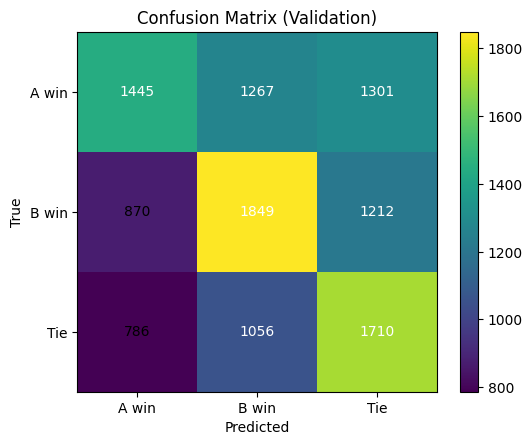

[viz] confusion matrix saved to: /kaggle/working/confusion_matrix_val.png
              precision    recall  f1-score   support

       A win     0.4660    0.3601    0.4062      4013
       B win     0.4432    0.4704    0.4564      3931
         Tie     0.4049    0.4814    0.4399      3552

    accuracy                         0.4353     11496
   macro avg     0.4380    0.4373    0.4342     11496
weighted avg     0.4393    0.4353    0.4338     11496

[analysis] misclassified: 6492 / 11496
[save] misclassified samples saved to: /kaggle/working/misclassified_val.csv
[Prompt]
["Name all the skills of Disco Elysium and format your answer as follows:\nName of skill - Relative rating of usefulness from 0 to 100 - Relative rating of interestingness from 0 to 100"]

[Response A]
["Skills of Disco Elysium:\n\n1.   Persuasion - 80\/100 - 80\/100\n2.   Intimidation - 80\/100 - 80\/100\n3.   Investigation - 80\/100 - 80\/100\n4.   Stealth - 80\/100 - 80\/100\n5.   Medicine - 70\/100 - 70\/100\n6. 

In [7]:
import os, sys, json, math, random, time
import numpy as np, pandas as pd
from typing import Dict, Tuple, Optional, List
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    get_cosine_schedule_with_warmup,
)
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


# ==== Utils ====
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ==== Dataset ====
class Pairwise3ClsDataset(Dataset):
    """
    입력: prompt, response_A, response_B → 3-class(0:A, 1:B, 2:tie)
    텍스트 포맷: [CLS] prompt [SEP] A [SEP] B
    """
    def __init__(self, df: pd.DataFrame, tokenizer, max_len: int = 384, has_label: bool = True):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.has_label = has_label

        # 컬럼 이름 표준화(안전)
        self.df = standardize_columns(self.df)

        need_cols = ["response_A", "response_B", "prompt"]
        for c in need_cols:
            if c not in self.df.columns:
                raise ValueError(f"Missing column: {c}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        prompt = str(row.get("prompt", "")) or ""
        a = str(row["response_A"])
        b = str(row["response_B"])

        # 텍스트 구성
        # DeBERTa도 sep_token 사용 가능
        sep = self.tokenizer.sep_token or "[SEP]"
        text = f"{prompt} {sep} [Response A] {a} {sep} [Response B] {b}"

        item = {"text": text}
        if self.has_label:
            label = int(row["label"])
            item["label"] = label
        else:
            item["id"] = row["id"]
        return item

def collate_fn_train(batch, tokenizer, max_len):
    texts = [b["text"] for b in batch]
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    labels = torch.tensor([b["label"] for b in batch], dtype=torch.long)
    return enc, labels

def collate_fn_test(batch, tokenizer, max_len):
    texts = [b["text"] for b in batch]
    ids = [b["id"] for b in batch]
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    return enc, ids

# ==== Training / Eval Routines ====
def get_optimizer(model, lr=2e-5, weight_decay=0.01):
    no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight"]
    param_groups = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    return torch.optim.AdamW(param_groups, lr=lr)

@torch.no_grad()
def evaluate(model, val_loader, device, label_smoothing=0.0, return_preds=False):
    model.eval()
    ce = nn.CrossEntropyLoss(label_smoothing=label_smoothing, reduction="mean")
    all_probs, all_labels = [], []
    total_loss = 0.0

    for enc, labels in val_loader:
        for k in enc:
            enc[k] = enc[k].to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        logits = model(**enc).logits
        loss = ce(logits, labels)
        total_loss += loss.item() * labels.size(0)

        probs = torch.softmax(logits, dim=-1).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    preds = np.argmax(all_probs, axis=1)

    val_logloss = log_loss(all_labels, all_probs, labels=[0,1,2])
    avg_loss = total_loss / len(val_loader.dataset)

    if return_preds:
        return avg_loss, val_logloss, all_probs, preds, all_labels
    return avg_loss, val_logloss, all_probs

def train_one_epoch(model, train_loader, optimizer, scheduler, device, scaler, grad_accum_steps=1, max_grad_norm=1.0, label_smoothing=0.0):
    model.train()
    ce = nn.CrossEntropyLoss(label_smoothing=label_smoothing, reduction="mean")

    running_loss = 0.0
    optimizer.zero_grad(set_to_none=True)

    for step, (enc, labels) in enumerate(train_loader):
        for k in enc:
            enc[k] = enc[k].to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=scaler is not None):
            outputs = model(**enc)
            logits = outputs.logits
            loss = ce(logits, labels) / grad_accum_steps

        if scaler is not None:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            if scaler is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            if scheduler is not None:
                scheduler.step()

        running_loss += loss.item() * grad_accum_steps

    return running_loss / len(train_loader)

# ==== Main Runner ====
def run_full_finetune(cfg: Dict):
    seed_everything(cfg.get("random_state", 42))

    # I/O
    train_df, test_df, submit_df = load_csvs(cfg)
    train_df = standardize_columns(train_df)
    test_df  = standardize_columns(test_df)

    # 라벨 생성(0:A, 1:B, 2:tie)
    train_df = build_label_threeway(train_df)

    # Split
    trn, val = train_test_split(
        train_df,
        test_size=cfg.get("val_size", 0.2),
        random_state=cfg.get("random_state", 42),
        stratify=train_df["label"]
    )
    trn = trn.reset_index(drop=True)
    val = val.reset_index(drop=True)

    # Tokenizer / Model
    model_name_or_path = cfg.get("model_dir", DEBERTA_DIR)
    num_labels = 3
    max_len = cfg.get("max_len", 384)

    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
    config = AutoConfig.from_pretrained(
        model_name_or_path,
        num_labels=num_labels,
        problem_type="single_label_classification",
        hidden_dropout_prob=0.2,          
        attention_probs_dropout_prob=0.1, 
        classifier_dropout=0.2            
    )
    model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, config=config)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Dataset / Loader
    train_ds = Pairwise3ClsDataset(trn, tokenizer, max_len=max_len, has_label=True)
    val_ds   = Pairwise3ClsDataset(val, tokenizer, max_len=max_len, has_label=True)
    test_ds  = Pairwise3ClsDataset(test_df, tokenizer, max_len=max_len, has_label=False)

    train_bs = cfg.get("train_batch_size", 8)
    val_bs   = cfg.get("valid_batch_size", 16)
    test_bs  = cfg.get("test_batch_size", 16)

    train_loader = DataLoader(train_ds, batch_size=train_bs, shuffle=True, num_workers=2,
                              pin_memory=True, collate_fn=lambda b: collate_fn_train(b, tokenizer, max_len))
    val_loader   = DataLoader(val_ds, batch_size=val_bs, shuffle=False, num_workers=2,
                              pin_memory=True, collate_fn=lambda b: collate_fn_train(b, tokenizer, max_len))
    test_loader  = DataLoader(test_ds, batch_size=test_bs, shuffle=False, num_workers=2,
                              pin_memory=True, collate_fn=lambda b: collate_fn_test(b, tokenizer, max_len))

    # Optim / Sched
    lr = cfg.get("lr", 2e-5)
    epochs = cfg.get("epochs", 5)
    grad_accum = cfg.get("grad_accum_steps", 1)
    warmup_ratio = cfg.get("warmup_ratio", 0.1)
    max_grad_norm = cfg.get("max_grad_norm", 1.0)
    label_smoothing = cfg.get("label_smoothing", 0.05)

    total_steps = math.ceil(len(train_loader) / grad_accum) * epochs
    warmup_steps = int(total_steps * warmup_ratio)

    optimizer = get_optimizer(model, lr=lr, weight_decay=cfg.get("weight_decay", 0.01))
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    # AMP
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

    # Early Stopping & Checkpoint
    patience = cfg.get("patience", 2)
    best_val_logloss = 1e9
    best_path = os.path.join(cfg["WORK_DIR"], "deberta3_small_fullFT_best.pt")
    no_improve = 0

    print(f"[init] Trainable params: {count_trainable_params(model):,}")
    print(f"[sched] total_steps={total_steps}, warmup_steps={warmup_steps}")
    print(f"[hp] epochs={epochs}, bs={train_bs}, accum={grad_accum}, lr={lr}, label_smoothing={label_smoothing}")

    for ep in range(1, epochs + 1):
        t0 = time.time()
        tr_loss = train_one_epoch(
            model, train_loader, optimizer, scheduler, device, scaler,
            grad_accum_steps=grad_accum, max_grad_norm=max_grad_norm, label_smoothing=label_smoothing
        )
        val_loss, val_logloss, _ = evaluate(model, val_loader, device, label_smoothing=label_smoothing)
        dt = time.time() - t0
        print(f"[epoch {ep}/{epochs}] train_loss={tr_loss:.4f}  val_loss={val_loss:.4f}  val_logloss={val_logloss:.5f}  ({dt:.1f}s)")

        if val_logloss < best_val_logloss - 1e-6:
            best_val_logloss = val_logloss
            torch.save({"model_state": model.state_dict(), "config": config.to_dict()}, best_path)
            print(f"  -> New best! saved: {best_path}")
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"  -> Early stopping (patience={patience})")
                break

    # Load best
    if os.path.exists(best_path):
        state = torch.load(best_path, map_location="cpu")
        model.load_state_dict(state["model_state"])
        model.to(device)
        print(f"[load] best checkpoint (val_logloss={best_val_logloss:.5f})")

        # ---------- Validation analysis: Confusion Matrix & Misclassified ----------
    val_loss, val_logloss, val_probs, val_preds, val_labels = evaluate(
        model, val_loader, device, label_smoothing=label_smoothing, return_preds=True
    )
    label_names = ["A win","B win","Tie"]

    # Confusion Matrix (표시 + 저장)
    cm = confusion_matrix(val_labels, val_preds, labels=[0,1,2])

    plt.figure(figsize=(5.5, 4.5))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix (Validation)")
    plt.colorbar()
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks, label_names, rotation=0)
    plt.yticks(tick_marks, label_names)
    # 숫자 표시
    thresh = cm.max() / 2.0 if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    cm_path = os.path.join(cfg["WORK_DIR"], "confusion_matrix_val.png")
    plt.savefig(cm_path, dpi=150)
    plt.show()
    print(f"[viz] confusion matrix saved to: {cm_path}")

    # Classification Report (콘솔)
    print(classification_report(val_labels, val_preds, target_names=label_names, digits=4))

    # Misclassified 샘플 정리(+ 저장)
    wrong_idx = np.where(val_preds != val_labels)[0]
    print(f"[analysis] misclassified: {len(wrong_idx)} / {len(val_labels)}")

    # val 데이터프레임에서 해당 행 매칭
    # (val_loader 순서 = val.reset_index(drop=True) 기반이므로 인덱스 align)
    val_reset = val.reset_index(drop=True).copy()
    mis_df = val_reset.iloc[wrong_idx].copy()
    mis_df["true_label"] = [label_names[i] for i in val_labels[wrong_idx]]
    mis_df["pred_label"] = [label_names[i] for i in val_preds[wrong_idx]]
    mis_df["p_A"] = val_probs[wrong_idx, 0]
    mis_df["p_B"] = val_probs[wrong_idx, 1]
    mis_df["p_Tie"] = val_probs[wrong_idx, 2]

    mis_path = os.path.join(cfg["WORK_DIR"], "misclassified_val.csv")
    cols = ["prompt","response_A","response_B","true_label","pred_label","p_A","p_B","p_Tie"]
    # 존재하는 컬럼만 저장(안전)
    cols = [c for c in cols if c in mis_df.columns]
    mis_df.to_csv(mis_path, index=False, columns=cols)
    print(f"[save] misclassified samples saved to: {mis_path}")

    # 콘솔에 샘플 몇 개만 보기
    show_n = min(5, len(wrong_idx))
    for i in range(show_n):
        ridx = wrong_idx[i]
        row = val_reset.iloc[ridx]
        print("="*80)
        print(f"[Prompt]\n{row.get('prompt','')}\n")
        print(f"[Response A]\n{row.get('response_A','')[:500]}...\n")
        print(f"[Response B]\n{row.get('response_B','')[:500]}...\n")
        print(f"✅ True: {label_names[val_labels[ridx]]} | ❌ Pred: {label_names[val_preds[ridx]]} | "
              f"p=[A:{val_probs[ridx,0]:.3f}, B:{val_probs[ridx,1]:.3f}, Tie:{val_probs[ridx,2]:.3f}]")

    # Inference on test
    model.eval()
    all_probs = []
    all_ids = []
    with torch.no_grad():
        for enc, ids in test_loader:
            for k in enc:
                enc[k] = enc[k].to(device, non_blocking=True)
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            all_probs.append(probs)
            all_ids.extend(ids)
    all_probs = np.concatenate(all_probs, axis=0)

    # Save submission
    out_csv = os.path.join(cfg["WORK_DIR"], "submission.csv")
    test_df_sorted = test_df.copy()
    # test_df에 id가 반드시 있다고 가정
    # 혹시 정렬이 섞였을 수 있으니 all_ids 순서대로 데이터프레임 맞추기
    test_df_sorted = test_df.set_index("id").loc[all_ids].reset_index()
    save_submission_threecols(test_df_sorted, all_probs, out_csv)
    print("[done]")

# ==== 실행 ====
CFG = {
    **BASE_ARGS,
    # 모델/학습 하이퍼파라미터
    "model_dir": DEBERTA_DIR,
    "max_len": 384,
    "train_batch_size": 8,     # VRAM 여유에 따라 8~16 권장
    "valid_batch_size": 16,
    "test_batch_size": 16,
    "epochs": 5,               # 4~6 범위 권장
    "lr": 1.2e-5,                # 1e-5 ~ 3e-5 사이 권장
    "weight_decay": 0.03,
    "grad_accum_steps": 1,     # VRAM 모자라면 2~4로
    "warmup_ratio": 0.06,
    "max_grad_norm": 1.0,
    "label_smoothing": 0.08,   # 0.0~0.1 사이에서 조절
    "patience": 2,             # early stopping
}

run_full_finetune(CFG)
